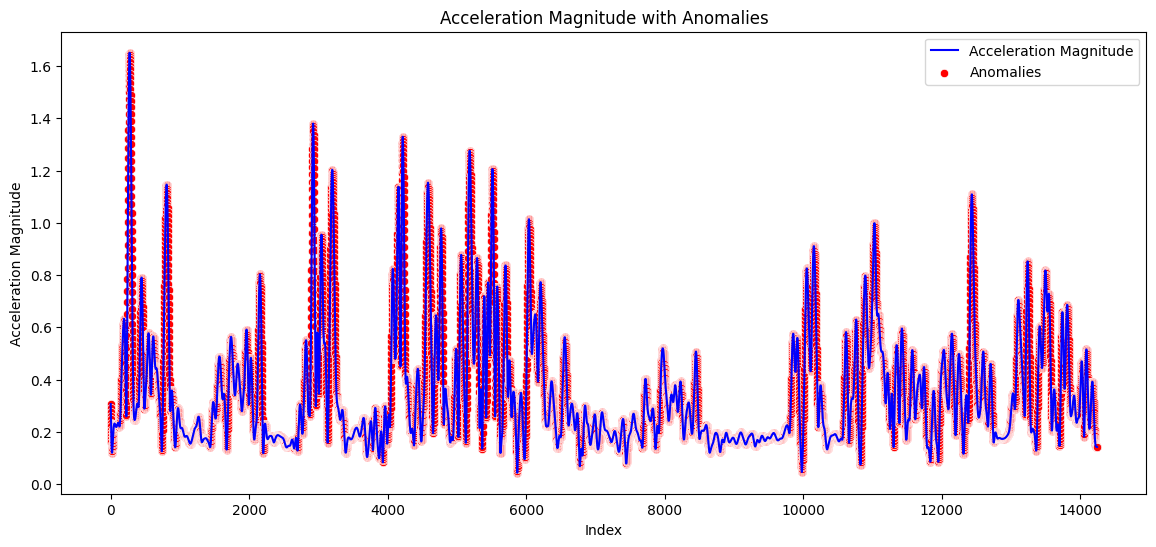

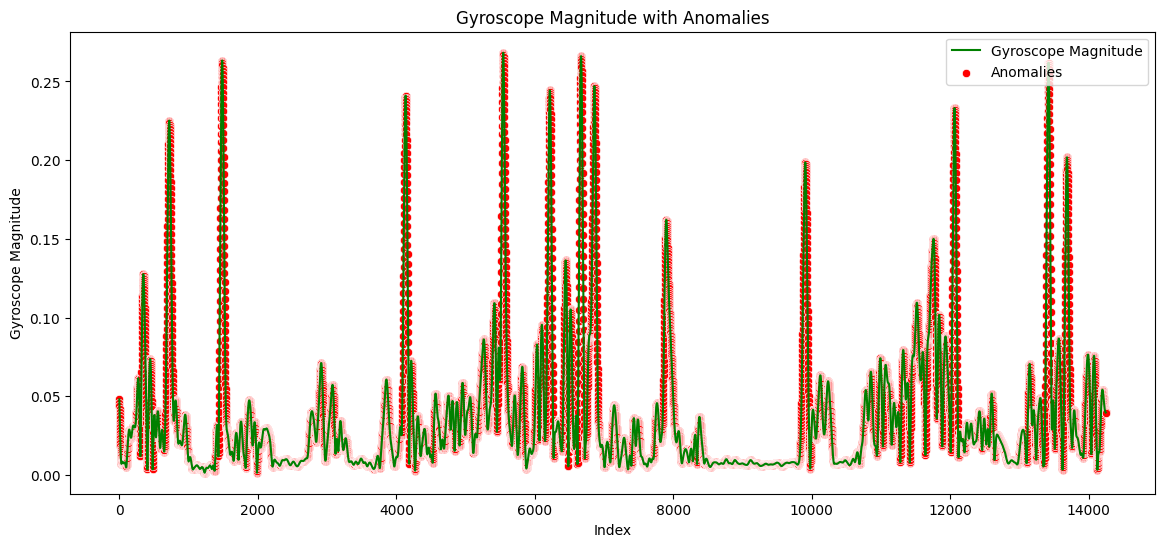

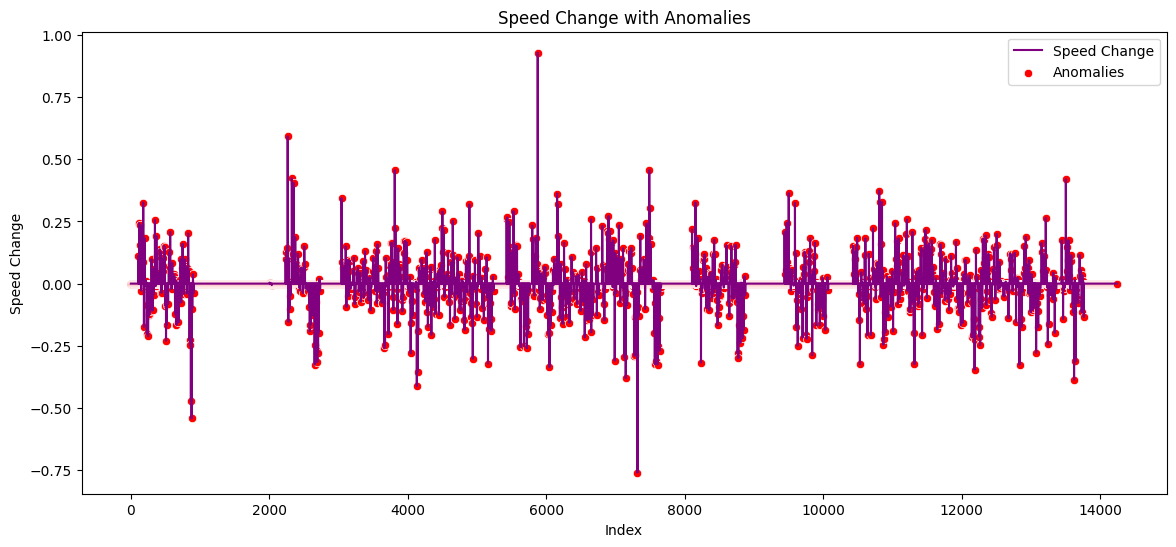

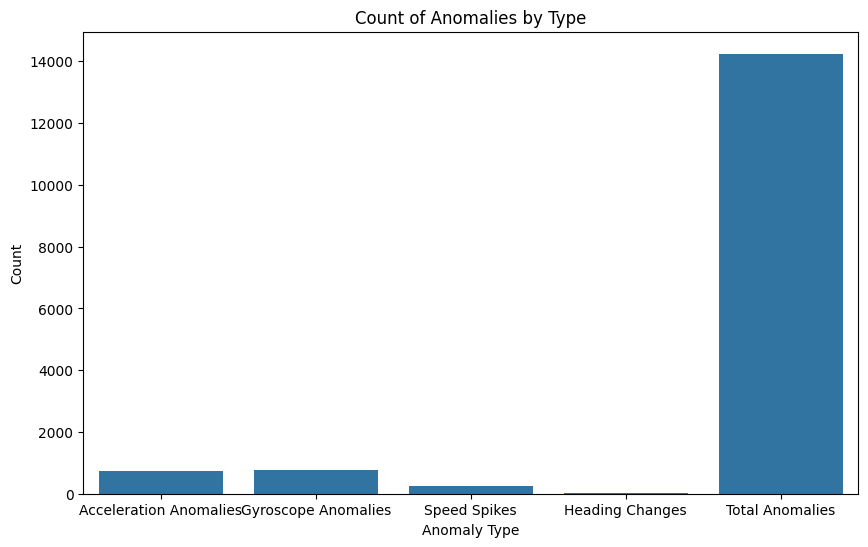

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from scipy.signal import butter, filtfilt

# Load your dataset (update the file path)
data = pd.read_csv('Featured_dataset.csv')

# Updated list of available features in your dataset
features = [
    'Acc X', 'Acc Y', 'Acc Z', 'gyro_x', 'gyro_y', 'gyro_z', 
    'Speed', 'Distance', 'Heading', 'Acc_Magnitude', 'Gyro_Magnitude', 
    'Speed_Change', 'Heading_Change', 'Acc_Change', 'Gyro_Change',
    'Net_Displacement', 'Rolling_Acc_Mean', 'Rolling_Acc_STD', 
    'acc_mean', 'acc_std', 'gyro_mean', 'gyro_std'
]

# Preprocessing: Check for missing data and handle it
data = data[features]
data = data.dropna()  # Dropping missing values, but you could also impute them if needed

# Filter noisy accelerometer/gyroscope data using a Butterworth filter
def butter_filter(data, cutoff=0.3, fs=30, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

# Apply the filter to accelerometer and gyroscope data
data['Acc_X_Filtered'] = butter_filter(data['Acc X'])
data['Acc_Y_Filtered'] = butter_filter(data['Acc Y'])
data['Acc_Z_Filtered'] = butter_filter(data['Acc Z'])
data['Gyro_X_Filtered'] = butter_filter(data['gyro_x'])
data['Gyro_Y_Filtered'] = butter_filter(data['gyro_y'])
data['Gyro_Z_Filtered'] = butter_filter(data['gyro_z'])

# Calculate Magnitudes (for accelerometer and gyroscope)
data['Acc_Magnitude_Filtered'] = np.sqrt(data['Acc_X_Filtered']**2 + data['Acc_Y_Filtered']**2 + data['Acc_Z_Filtered']**2)
data['Gyro_Magnitude_Filtered'] = np.sqrt(data['Gyro_X_Filtered']**2 + data['Gyro_Y_Filtered']**2 + data['Gyro_Z_Filtered']**2)

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[features])

# Anomaly Detection with Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
data['anomaly_score'] = iso_forest.fit_predict(data_scaled)

# Detect anomalies in specific columns (example: sudden spikes in Acceleration)
data['high_acc'] = data['Acc_Magnitude_Filtered'] > data['Acc_Magnitude_Filtered'].mean() + 2 * data['Acc_Magnitude_Filtered'].std()
data['high_gyro'] = data['Gyro_Magnitude_Filtered'] > data['Gyro_Magnitude_Filtered'].mean() + 2 * data['Gyro_Magnitude_Filtered'].std()
data['speed_spike'] = data['Speed_Change'] > data['Speed_Change'].mean() + 2 * data['Speed_Change'].std()
data['heading_change'] = data['Heading_Change'] > data['Heading_Change'].mean() + 2 * data['Heading_Change'].std()

# Combine anomalies into a total anomaly score
data['total_anomaly'] = data[['anomaly_score', 'high_acc', 'high_gyro', 'speed_spike', 'heading_change']].any(axis=1)

# Visualizations

# 1. Acceleration Magnitude Over Time (with anomalies highlighted)
plt.figure(figsize=(14, 6))
sns.lineplot(data=data, x=data.index, y='Acc_Magnitude_Filtered', label="Acceleration Magnitude", color='blue')
sns.scatterplot(data=data[data['total_anomaly']], x=data[data['total_anomaly']].index, y='Acc_Magnitude_Filtered', color='red', label="Anomalies")
plt.title("Acceleration Magnitude with Anomalies")
plt.xlabel("Index")
plt.ylabel("Acceleration Magnitude")
plt.legend()
plt.show()

# 2. Gyroscope Magnitude Over Time (with anomalies highlighted)
plt.figure(figsize=(14, 6))
sns.lineplot(data=data, x=data.index, y='Gyro_Magnitude_Filtered', label="Gyroscope Magnitude", color='green')
sns.scatterplot(data=data[data['total_anomaly']], x=data[data['total_anomaly']].index, y='Gyro_Magnitude_Filtered', color='red', label="Anomalies")
plt.title("Gyroscope Magnitude with Anomalies")
plt.xlabel("Index")
plt.ylabel("Gyroscope Magnitude")
plt.legend()
plt.show()

# 3. Speed Change Over Time (with anomalies)
plt.figure(figsize=(14, 6))
sns.lineplot(data=data, x=data.index, y='Speed_Change', label="Speed Change", color='purple')
sns.scatterplot(data=data[data['total_anomaly']], x=data[data['total_anomaly']].index, y='Speed_Change', color='red', label="Anomalies")
plt.title("Speed Change with Anomalies")
plt.xlabel("Index")
plt.ylabel("Speed Change")
plt.legend()
plt.show()

# 4. Count of anomalies per type
anomaly_counts = {
    'Acceleration Anomalies': data['high_acc'].sum(),
    'Gyroscope Anomalies': data['high_gyro'].sum(),
    'Speed Spikes': data['speed_spike'].sum(),
    'Heading Changes': data['heading_change'].sum(),
    'Total Anomalies': data['total_anomaly'].sum()
}

plt.figure(figsize=(10, 6))
sns.barplot(x=list(anomaly_counts.keys()), y=list(anomaly_counts.values()))
plt.title("Count of Anomalies by Type")
plt.xlabel("Anomaly Type")
plt.ylabel("Count")
plt.show()
